In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("customer_churn_dataset-testing-master.csv")
df.head()


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [2]:
df.info()
df.describe()

# No missing values as per previous check
df.isnull().sum()

# Convert Churn to integer
df['Churn'] = df['Churn'].astype(int)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [3]:
df['AgeGroup'] = pd.cut(
    df['Age'],
    bins=[17,25,35,45,55,65,100],
    labels=['18-25','26-35','36-45','46-55','56-65','65+']
)


### SQL queries


In [7]:
!pip install pandasql


  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=e2759446052caf130a46ba5fb6b77f776cbd9420fce0933ad04393f941d969a3
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [8]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())


Churn Count by Subscription Type

In [9]:
q1 = """
SELECT `Subscription Type`, COUNT(*) AS churned
FROM df
WHERE Churn = 1
GROUP BY `Subscription Type`
ORDER BY churned DESC;
"""
pysqldf(q1)


,Subscription Type,churned
0,Basic,10356
1,Standard,10177
2,Premium,9960


Average Payment Delay vs Churn

In [10]:
q2 = """
SELECT Churn, AVG(`Payment Delay`) AS avg_delay
FROM df
GROUP BY Churn;
"""
pysqldf(q2)


,Churn,avg_delay
0,0,12.453086
1,1,22.334897


Contract Length vs Churn

In [11]:
q3 = """
SELECT `Contract Length`, SUM(Churn) AS churn_count
FROM df
GROUP BY `Contract Length`
ORDER BY churn_count DESC;
"""
pysqldf(q3)


,Contract Length,churn_count
0,Monthly,11421
1,Annual,9895
2,Quarterly,9177


High-risk Customers (Segment)


In [12]:
q4 = """
SELECT *
FROM df
WHERE Churn = 1
AND `Payment Delay` > 15
AND `Support Calls` > 4;
"""
pysqldf(q4)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,AgeGroup
0,7,47,Female,37,15,9,28,Basic,Quarterly,574,14,1,46-55
1,11,46,Female,42,27,9,21,Standard,Annual,526,3,1,46-55
2,30,44,Female,44,7,8,16,Basic,Quarterly,792,27,1,36-45
3,38,56,Female,27,15,8,24,Standard,Monthly,384,6,1,56-65
4,41,29,Female,28,23,7,16,Basic,Quarterly,1000,26,1,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22263,64370,45,Female,33,12,6,21,Basic,Quarterly,947,14,1,36-45
22264,64371,37,Male,6,1,5,22,Standard,Annual,923,9,1,36-45
22265,64372,25,Male,39,14,8,30,Premium,Monthly,327,20,1,18-25
22266,64373,50,Female,18,19,7,22,Standard,Monthly,540,13,1,46-55


## Visualization

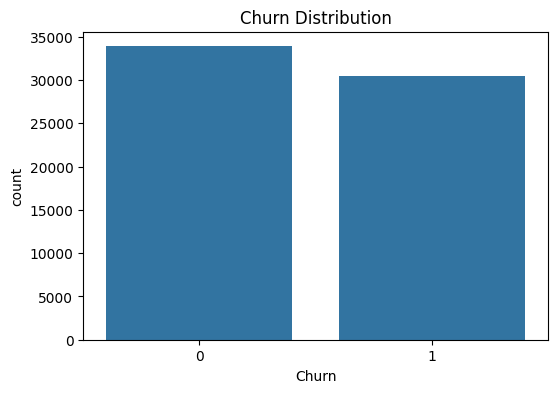

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

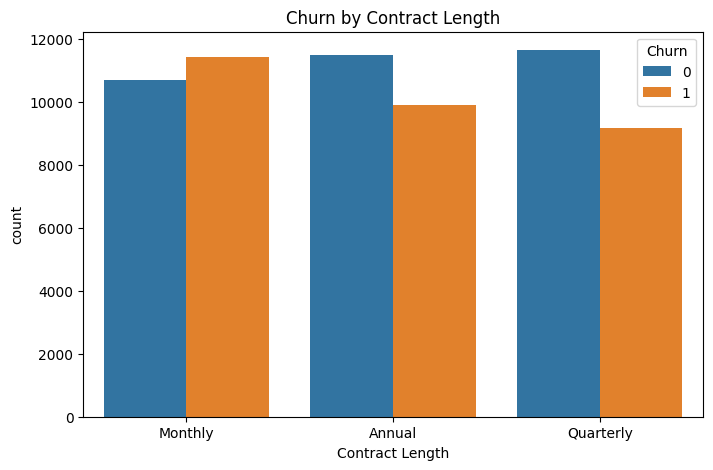

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x='Contract Length', hue='Churn', data=df)
plt.title("Churn by Contract Length")
plt.show()

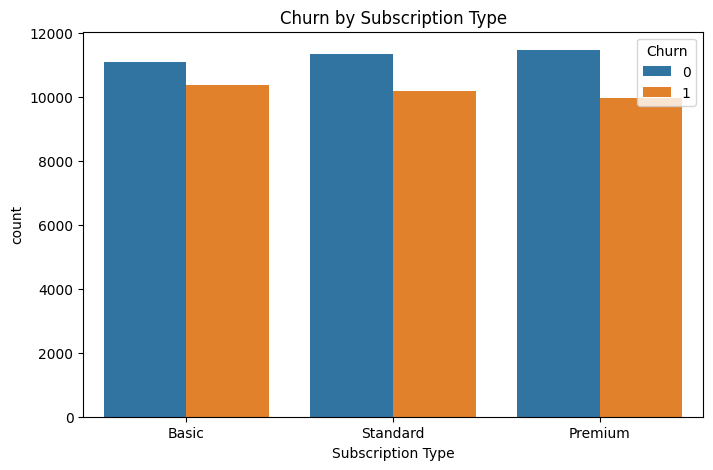

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(x='Subscription Type', hue='Churn', data=df)
plt.title("Churn by Subscription Type")
plt.show()

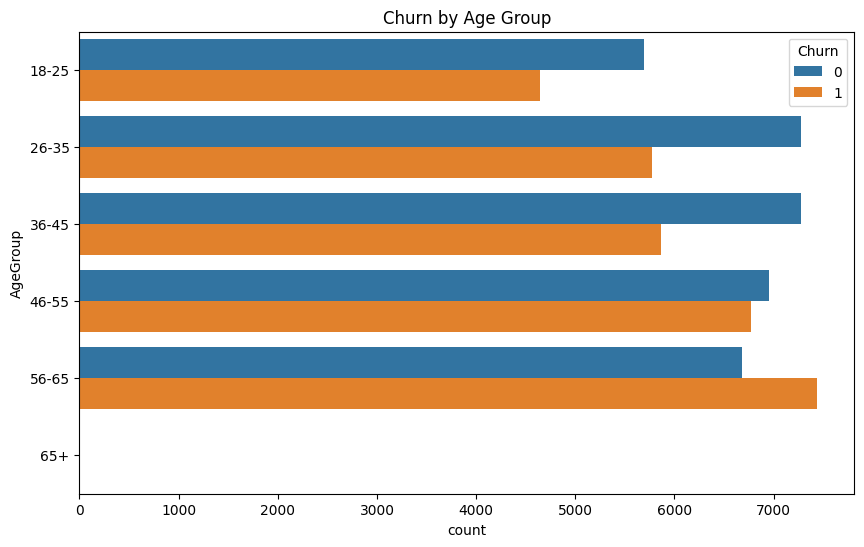

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(y='AgeGroup', hue='Churn', data=df)
plt.title("Churn by Age Group")
plt.show()


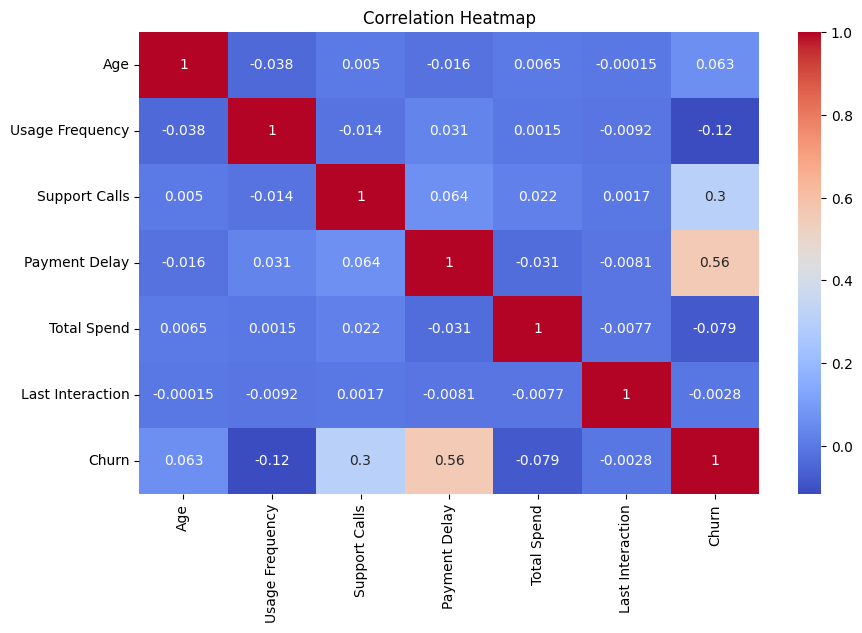

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['Age','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction','Churn']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
